# Analyzing 311 Noise Complaints Data

In [1]:
import urllib2, json, csv
import requests
import itertools
import numpy

from shapely.geometry import shape, Point
from rtree import index
from datetime import datetime, date, timedelta

######################### UTILS #########################
def readJson(url):
    """
    Read a json file.
    :param url: url to be read.
    :return: a json file.
    """
    try:
        response = urllib2.urlopen(url)
        return json.loads(response.read(), strict=False)
    except urllib2.HTTPError as e:
        return None
    
def roundTime(dt=None, roundTo=60):
   """
   Round a datetime object to any time laps in seconds
   :param dt: datetime.datetime object, default now.
   :param roundTo: closest number of seconds to round to, default 1 minute.
   :return: the rounded time.
   """
   if dt == None : dt = datetime.now()
   seconds = (dt - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + timedelta(0, rounding-seconds, -dt.microsecond)

######################### DATA #########################
def getRegions():
    """
    Get the community districts of NY.
    :return: dictionary { region id : coordinates}.
    """
    dict = {}

    url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:22:23.125Z/community-districts-polygon.geojson"
    data = readJson(url)
    for district in data['features']:
        dict[district['id']] = shape(district['geometry'])

    return dict

def get311NoiseComplaints():
    """
    Gets all noise complaints of NY in a date range.
    :return: dictionary {complaint type : total number of complaints of this type} and 
             dictionary {complaint type : (long/lat, hour, complaint type)}.
    """
    query_string = "http://data.cityofnewyork.us/resource/fhrw-4uyv.json"
    query_string += "?"
    query_string += "$where="
    query_string += "(complaint_type like '%Noise%')"
    query_string += " AND "
    query_string += "(created_date>='" + date_ini + "')"
    query_string += " AND "
    query_string += "(created_date<='" + date_end + "')"
    query_string += "&$group=descriptor,latitude,longitude,created_date"
    query_string += "&$select=descriptor,latitude,longitude,created_date"

    result = requests.get(query_string).json()
    
    print query_string

    # Dictionary of complaints
    complaints = {'Air Condition/Ventilation Equipment': 0, 'Alarms': 0,
                  'Banging/Pounding': 0, 'Barking Dog': 0, 'Car/Truck Horn': 0,
                  'Car/Truck Music': 0, 'Construction Equipment': 0,
                  'Construction Before/After Hours': 0, 'Engine Idling': 0,
                  'Ice Cream Truck': 0, 'Jack Hammering': 0, 'Lawn Care Equipment': 0,
                  'Loud Music/Party': 0, 'Loud Talking': 0, 'Loud Television': 0,
                  'Manufacturing Noise': 0, 'Others': 0, 'Private Carting Noise': 0}

    complaints_loc = {}
    for key in complaints:
        complaints_loc[key] = []

    for record in result:
        for key in complaints:
            date = record.get('created_date')
            long = record.get('longitude')
            lat = record.get('latitude')
            if date is not None and long is not None and lat is not None:
                time = roundTime(datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.000'), roundTo=60 * 60)
                if record.get('descriptor').find(key) > -1:
                    complaints[key] += 1
                    complaints_loc[key].append((float(str(long)), float(str(lat)), time, key))
                    break
                elif key == "Others":
                    complaints[key] += 1
                    complaints_loc[key].append((float(str(long)), float(str(lat)), time, key))

    return complaints, complaints_loc

######################### FILTER BY REGION #########################
def pointInPolygon(polyDict, points):
    """
    Defines which points are inside which regions.
    :param polyDict: dictionary {region id : polygon}.
    :param points: list of tuples (long, lat).
    :return: dictionaries {region id : number of points} and {region id : points}.
    """
    dict_count = {}
    dict_points = {}

    polygons = []
    # Populate R-tree index with bounds of polygons
    idx = index.Index()
    for pos, poly in enumerate(polyDict):
        dict_count[poly] = 0
        dict_points[poly] = []
        polygon = shape(polyDict[poly])
        polygons.append(polygon)
        idx.insert(pos, polygon.bounds)

    for i, p in enumerate(points):
        point = Point(p[0], p[1])
        # Iterate through spatial index
        for j in idx.intersection(point.coords[0]):
            if point.within(polygons[j]):
                dict_count[j] += 1
                dict_points[j].append(p)

    return dict_count, dict_points

def complaintsPerRegion(regions, complaints):
    """
    Obtain the total number of complaints that falls in a reiong, per hour.
    :param regions: dictionary {region id : polygon}.
    :param complaints: dictionary {complaint type : (long, lat, hour)}.
    return: dictionary {region id : (long/lat, hour, complaint type)}
    """
    values = list(itertools.chain.from_iterable(complaints.values()))
    complaints_per_region, complaints_per_region_points = pointInPolygon(regions, values)

    return complaints_per_region, complaints_per_region_points

In [2]:
if __name__ == '__main__':
    date_ini = str(date(2015, 01, 01))
    date_end = str(date(2015, 12, 31))
    print "-----> Date Range:", date_ini, date_end

    regions_bbox = getRegions()
    regions_number = len(regions_bbox)
    print "-----> Number of regions:", regions_number

    complaints, complaints_loc = get311NoiseComplaints()
    print "----->", sum([v for v in complaints.values()]), "complaints"
    complaints_per_region, complaints_region_time = complaintsPerRegion(regions_bbox, complaints_loc)

-----> Date Range: 2015-01-01 2015-12-31
-----> Number of regions: 149
http://data.cityofnewyork.us/resource/fhrw-4uyv.json?$where=(complaint_type like '%Noise%') AND (created_date>='2015-01-01') AND (created_date<='2015-12-31')&$group=descriptor,latitude,longitude,created_date&$select=descriptor,latitude,longitude,created_date
-----> 984 complaints


# 311 Complaints Time Series Visualization

## General Overview 

### 1. Number of Complaints per Category

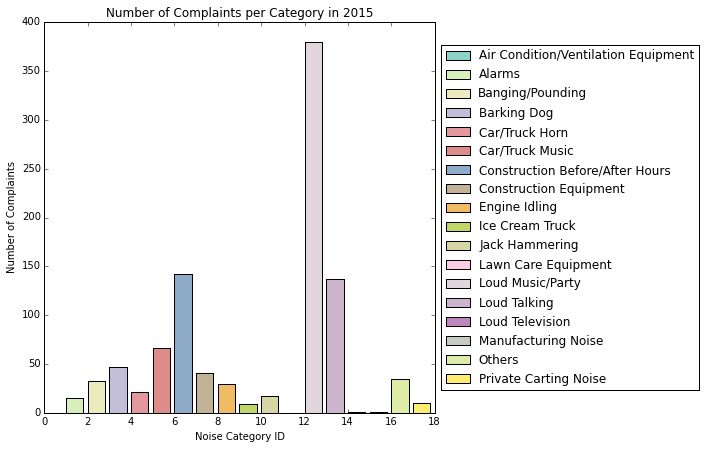

In [3]:
%matplotlib inline

import numpy
import matplotlib
import matplotlib.pyplot as plt

import collections

cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in numpy.linspace(0, 1, len(complaints))]
complaints = collections.OrderedDict(sorted(complaints.items()))

plt.figure(figsize=(7, 7), dpi=200)
item = 0
for key, value in complaints.iteritems():
    plt.bar(item, value, label=key, color=colors[item])
    item += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.xlabel('Noise Category ID')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Category in 2015')

As can be seen, the top noise complaint is related to **Loud Music/Party**, followed with a large distance by **Construction Before/After Hours** and **Loud Television**. **Air Condition/Ventilation Equipment** and **Lawn Care Equipement** related complaints were not registered for the year of 2015 in this data set.

### 2. Number Complaints Per Region

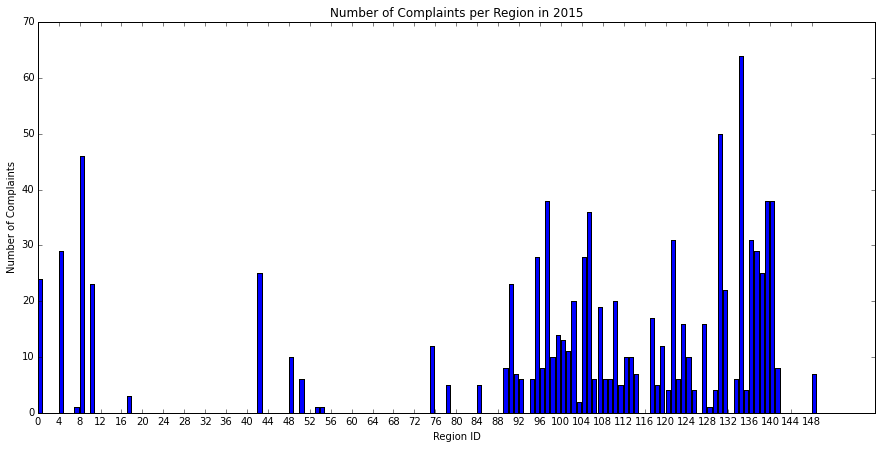

In [4]:
plt.figure(figsize=(15, 7), dpi=200)
item = 0
for key, value in complaints_per_region.iteritems():
    plt.bar(item, value, label=int(key)) 
    item += 1
plt.xticks(numpy.arange(0, 149, 4))
plt.xlabel('Region ID')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Region in 2015')

In [5]:
top_noisy = collections.OrderedDict(sorted(complaints_per_region.items(), key=lambda x:x[1], reverse=True))
top_noisy = itertools.islice(top_noisy.items(), 0, 5)

for key, value in top_noisy:
    print 'Region', key, ':', value

Region 134 : 64
Region 130 : 50
Region 8 : 46
Region 97 : 38
Region 139 : 38


Region 134 is **Washington Heights**, 8 is **Upper East Side**, 130 is **Williamsburg/Greenpoint**, 97 is **Greenwich Village/SoHo/Little Italy/West Village** and 140 is **Brooklyn Heights/Downton/Fort Greene**.

### 3. Filtering by Time

In [6]:
def get_complaints_by_time(complaints_region_time):
    complaints_time = {}
    for key in complaints:
            complaints_time[key] = []

    for key, value in complaints_region_time.iteritems():
        for item in value:
            new_key = item[3]
            new_value = item[2]
            complaints_time[new_key].append(new_value)

    complaints_hour = numpy.zeros((18, 24))
    complaints_weekday = numpy.zeros((18, 7))
    complaints_month = numpy.zeros((18, 12))
    complaints_day = numpy.zeros((18, 365))

    complaints_time = collections.OrderedDict(sorted(complaints_time.items()))  # To guarantee keys order
    index = 0
    for key, value in complaints_time.iteritems():
        for item in value:
            hour = item.hour          # Between 0 and 23
            weekday = item.weekday()  # Starts on Monday
            month = item.month - 1    # Between 1 and 12
            day_of_year = item.timetuple().tm_yday

            complaints_hour[index, hour] += 1
            complaints_weekday[index, weekday] += 1
            complaints_month[index, month] += 1
            complaints_day[index, day_of_year] += 1
        index += 1
        
    return complaints_hour, complaints_weekday, complaints_month, complaints_day

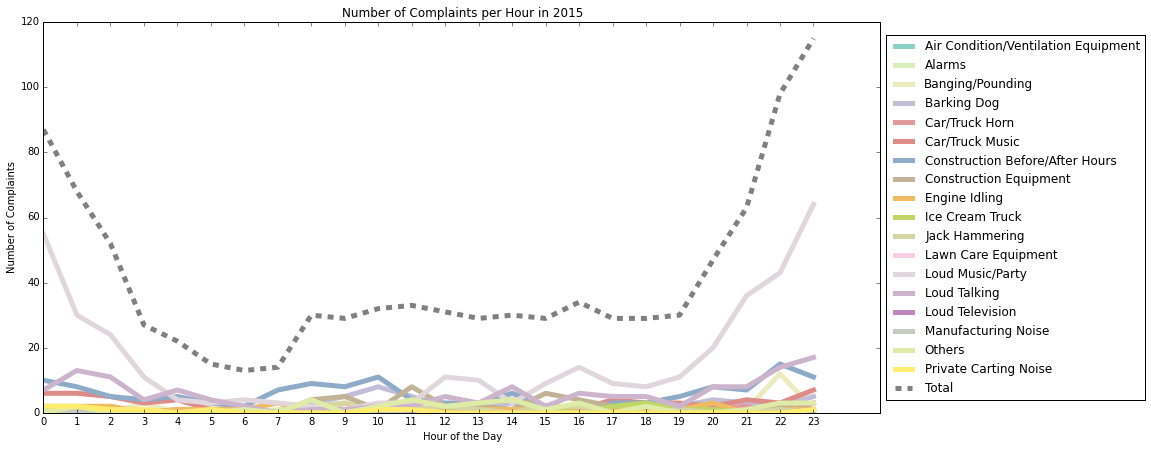

In [7]:
complaints_hour, complaints_weekday, complaints_month, complaints_day = get_complaints_by_time(complaints_region_time)

keys = sorted(complaints.keys())
y = range(complaints_hour.shape[1])

plt.figure(figsize=(15, 7), dpi=200)
for i in range(complaints_hour.shape[0]):
    plt.plot(y, complaints_hour[i,:], label=keys[i], color=colors[i], linewidth=5)
plt.plot(y, numpy.sum(complaints_hour, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xticks(numpy.arange(0, 24, 1))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Hour in 2015')

In general, the most complaints records regards to **Loud Music/Party**, followed by **Loud Talking** and **Construction Before/After Hours**. It's also possible to note that the number of complaints increases significantly after 19pm, decreasing after midnigh. This may show that people are less intolarent to noise at night, when they are at home wanting to rest. At 7am, the number of complaints grows again, but it remains at a similar level until 19pm.

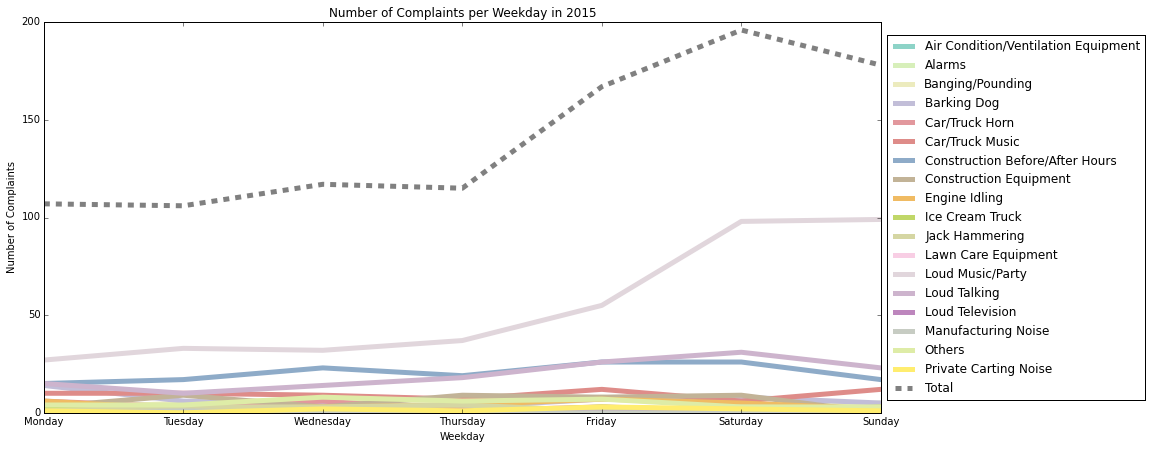

In [8]:
y = range(complaints_weekday.shape[1])

plt.figure(figsize=(15, 7), dpi=200)
for i in range(complaints_weekday.shape[0]):
    plt.plot(y, complaints_weekday[i,:], label=keys[i], color=colors[i], linewidth=5)
plt.plot(y, numpy.sum(complaints_weekday, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Weekday')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Weekday in 2015')

We can see now that the number of complaints increases on *Tuesdays*, being around 100 until *Thursdays*, when it increases rapidly, having its peak on Saturday, dropping again on *Sundays*. This may show that, as expected, as the week approaches to an end, more people go out, generating more noise. Saturdary, for example, has the higher number of complaints, which may be expected, once people don't have to worry about working on Sundays. Once again, the complaint category that prevails is **Loud Music/Party**.

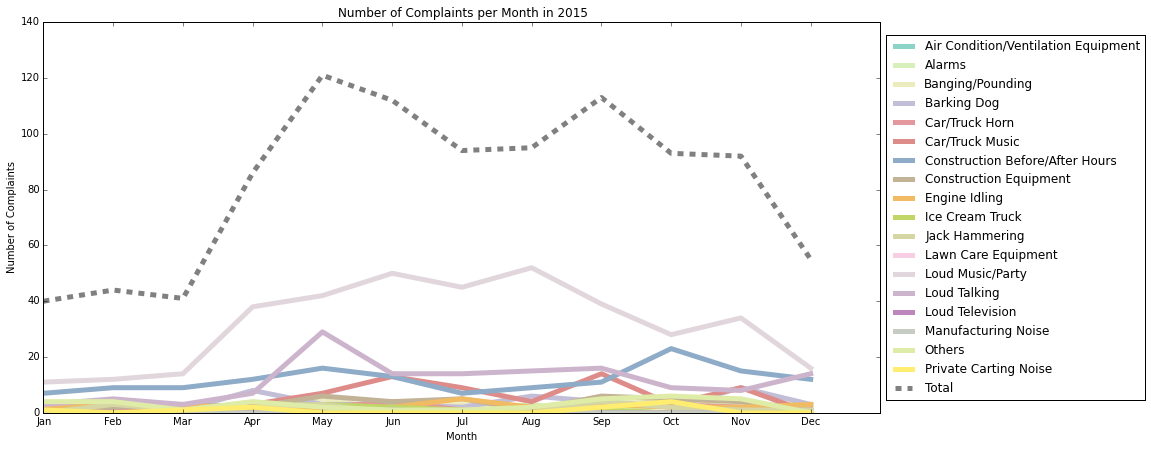

In [9]:
y = range(complaints_month.shape[1])

plt.figure(figsize=(15, 7), dpi=200)
for i in range(complaints_month.shape[0]):
    plt.plot(y, complaints_month[i,:], label=keys[i], color=colors[i], linewidth=5)
plt.plot(y, numpy.sum(complaints_month, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Month in 2015')

One can see now that the number of complaints grows abruptly from *March* to *April*, decreasing again in *November*. It can be expected that the number of complaints throuhg *December-March* is lower then in the other months of the year because is winter, i.e., probably less people go out, expecially to party. It's curious, however, that the number of complaints regarding **Loud Music/Party** decrease from June to July, since this is summer time. The same occurs to **Car/Truck Music** and **Construction Before/After Hours**. For the first categories, maybe more people are traveling (or just happier and more tolerant to noise). For the last one, maybe the number of planned construction during summer deacreases due the number of tourists expected in the city -- constructions could affect the traffic. This need further investigation.

## Analyzing Top Noisy Regions

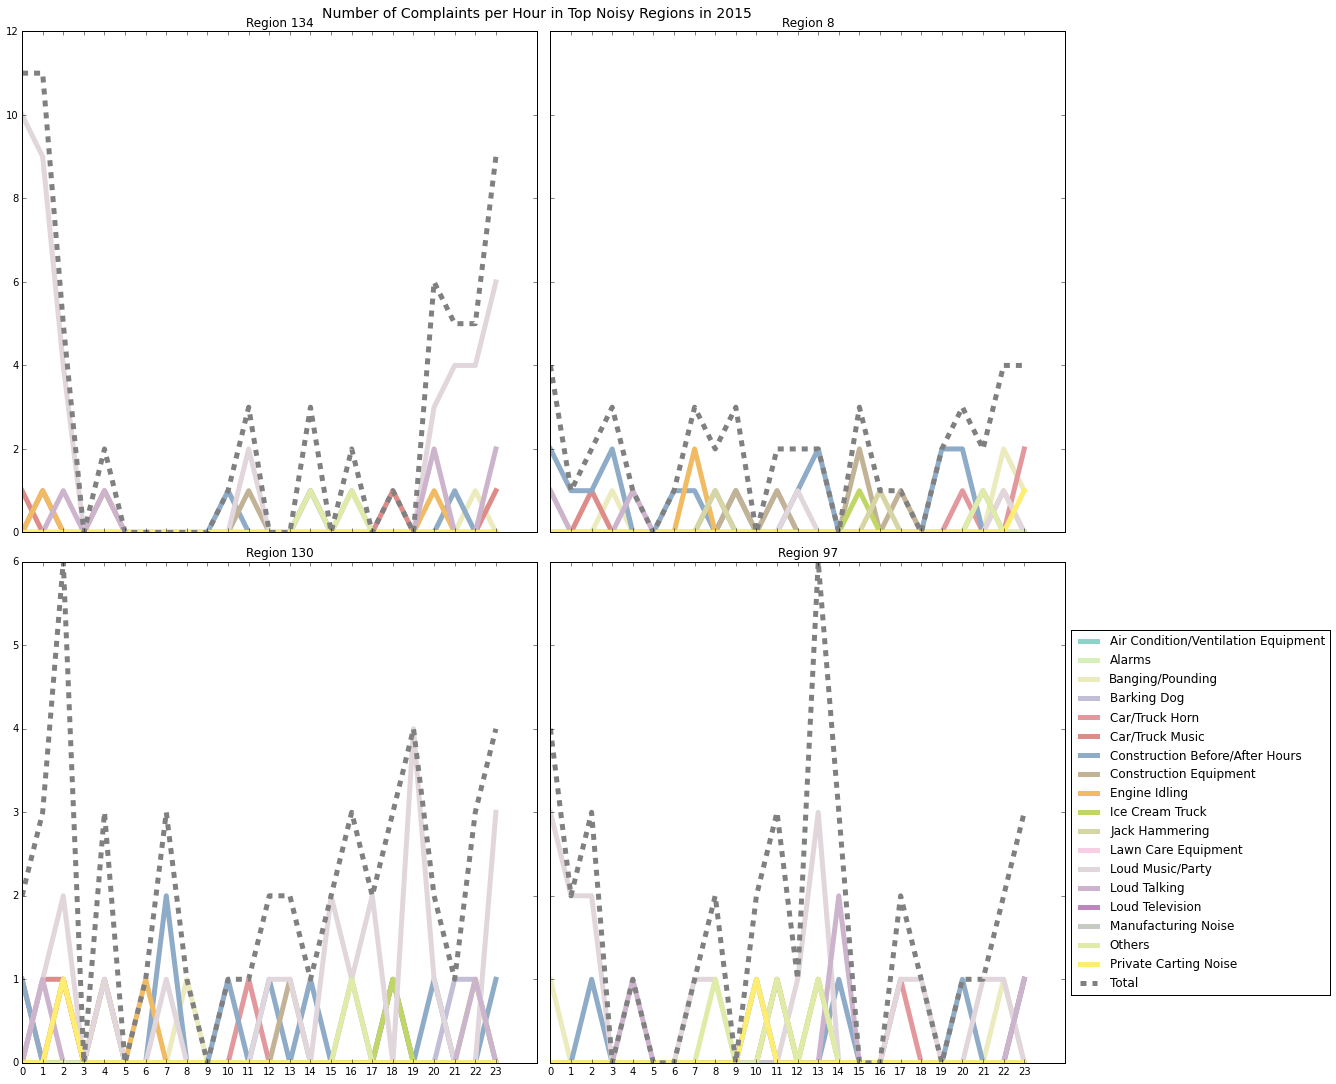

In [10]:
complaints_hour_134, complaints_weekday_134, complaints_month_134, complaints_day_134 = get_complaints_by_time({134 : complaints_region_time[134]})
complaints_hour_8, complaints_weekday_8, complaints_month_8, complaints_day_8 = get_complaints_by_time({8 : complaints_region_time[8]})
complaints_hour_130, complaints_weekday_130, complaints_month_130, complaints_day_130 = get_complaints_by_time({130 : complaints_region_time[130]})
complaints_hour_97, complaints_weekday_97, complaints_month_97, complaints_day_97 = get_complaints_by_time({97 : complaints_region_time[97]})

y = range(complaints_hour.shape[1])
f, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 15))
for i in range(complaints_hour.shape[0]):
    axes[0][0].plot(y, complaints_hour_134[i,:], label=keys[i], color=colors[i], linewidth=5)
    axes[0][1].plot(y, complaints_hour_8[i,:],   label=keys[i], color=colors[i], linewidth=5)
    axes[1][0].plot(y, complaints_hour_130[i,:], label=keys[i], color=colors[i], linewidth=5)
    axes[1][1].plot(y, complaints_hour_97[i,:],  label=keys[i], color=colors[i], linewidth=5)
axes[0][0].plot(y, numpy.sum(complaints_hour_134, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
axes[0][1].plot(y, numpy.sum(complaints_hour_8, axis=0),   label='Total', color='gray', linewidth=5, linestyle='--')
axes[1][0].plot(y, numpy.sum(complaints_hour_130, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
axes[1][1].plot(y, numpy.sum(complaints_hour_97, axis=0),  label='Total', color='gray', linewidth=5, linestyle='--')
axes[0][0].set_title('Region 134')
axes[0][1].set_title('Region 8')
axes[1][0].set_title('Region 130')
axes[1][1].set_title('Region 97')
plt.suptitle('Number of Complaints per Hour in Top Noisy Regions in 2015', fontsize=14, x=0.5, y=1.0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.setp(axes, xticks=numpy.arange(0, 24, 1))
plt.tight_layout()

**Washington Heights** (134) presents a considerable growth on hte number of complaints, mainly regarding **Loud Music/Party**, after 19pm, which drops after midnight, following the commom pattern observed previously. **Loud Talking** is the second frequent noise complaint in this region. 

The **Upper East Side** (8), on the other hand, doesn't show a prevalent patter. Complaints seem to rise a little bit after 17pm, dropping at 20pm. Is this region, the top noise complaint seems to be **Construction Before/After Hours**. 

On the other hand **Williamsburg/Greenpoint** (130) have a peak of complaints at 18pm, which regards mainly to **Loud Music/Party** and **Ice Cream Truck** and at 2am, related to **Loud Music/Party** and as **Car/Truck Music** and **Private Carging Noise**. 

The **Greenwich Village/SoHo/Little Italy/West Village** (97), at last presents a growth in the number of complaints at midday, which drops at 15pm. These complaints comprehends **Loud Music/party**, **Loud Talking** and **Construction Before/After Hours**. This region also presents a increase in this numver starting at 19pm and droppring at 3am. In this time span, the complaints are related to **Loud Music/Party**, **Banging/Pouding** and **Construction Before/After Hours**.

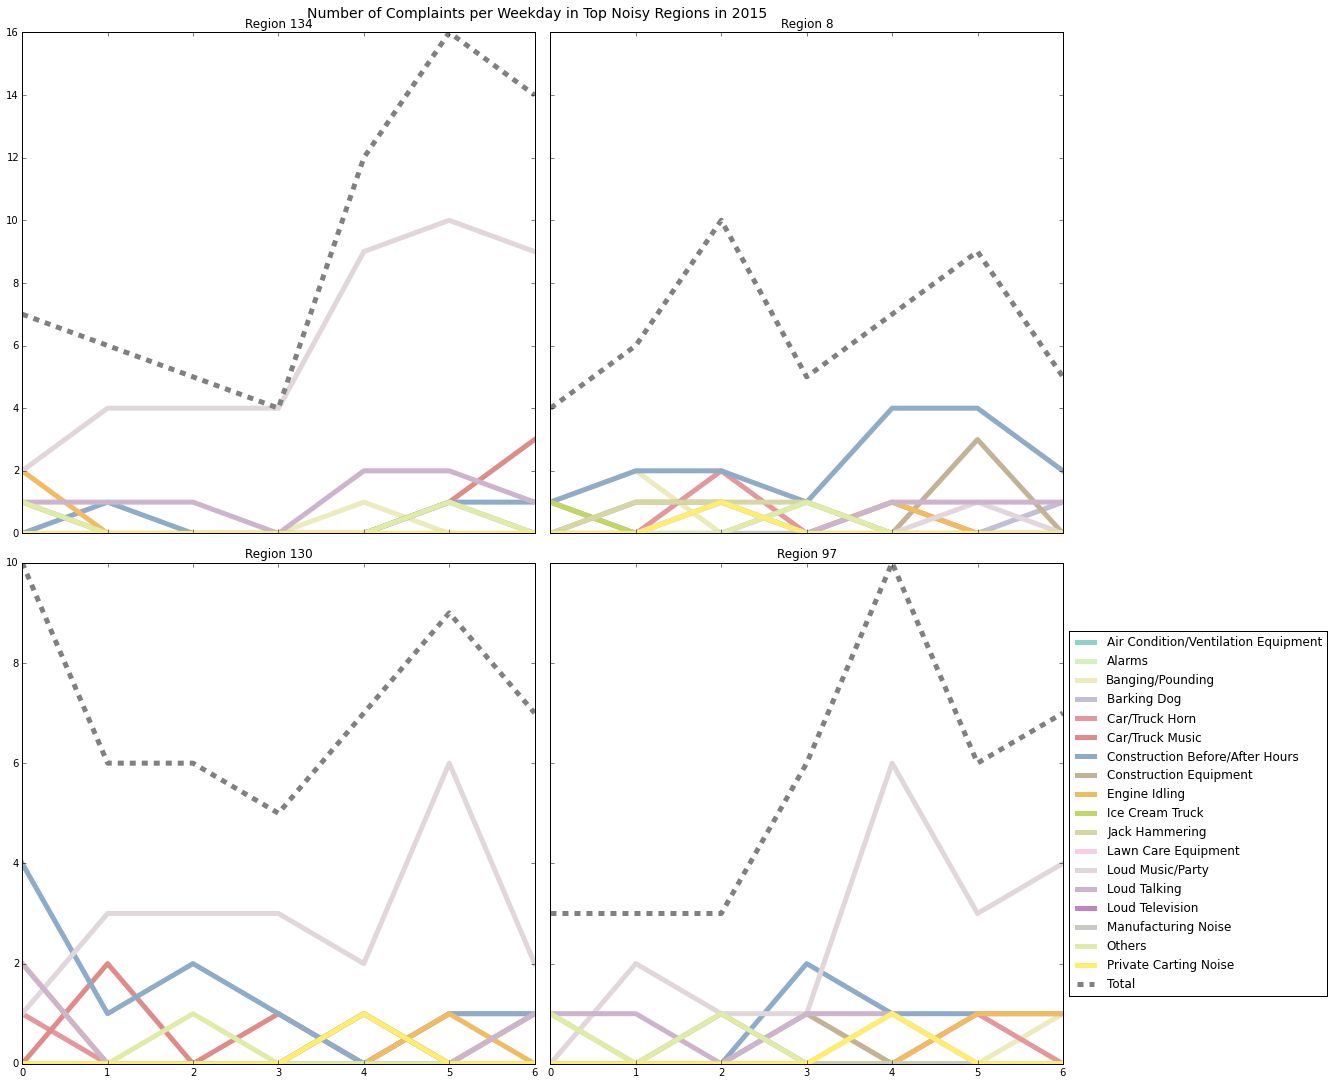

In [11]:
y = range(complaints_weekday.shape[1])
f, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 15))
for i in range(complaints_hour.shape[0]):
    axes[0][0].plot(y, complaints_weekday_134[i,:], label=keys[i], color=colors[i], linewidth=5)
    axes[0][1].plot(y, complaints_weekday_8[i,:],   label=keys[i], color=colors[i], linewidth=5)
    axes[1][0].plot(y, complaints_weekday_130[i,:], label=keys[i], color=colors[i], linewidth=5)
    axes[1][1].plot(y, complaints_weekday_97[i,:],  label=keys[i], color=colors[i], linewidth=5)
axes[0][0].plot(y, numpy.sum(complaints_weekday_134, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
axes[0][1].plot(y, numpy.sum(complaints_weekday_8, axis=0),   label='Total', color='gray', linewidth=5, linestyle='--')
axes[1][0].plot(y, numpy.sum(complaints_weekday_130, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
axes[1][1].plot(y, numpy.sum(complaints_weekday_97, axis=0),  label='Total', color='gray', linewidth=5, linestyle='--')
axes[0][0].set_title('Region 134')
axes[0][1].set_title('Region 8')
axes[1][0].set_title('Region 130')
axes[1][1].set_title('Region 97')
plt.suptitle('Number of Complaints per Weekday in Top Noisy Regions in 2015', fontsize=14, x=0.5, y=1.001)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.setp(axes, xticks=range(7))
plt.tight_layout()

**Washington Heights** (134) shows an increase in the number of complaints starting in *Thursdays*, which regards mainly to **Loud Music/Party**. This number drops on *Sundays*. This behavior, as mentioned before, seems expected.

The **Upper East Side** (8), also presnts an increase in the number of complaints starting in *Thursday*. However, this is mainly related to **Construction Before/After Hours**. Is this region, the top noise complaint seems to be **Construction Before/After Hours**. This region has been presenting a great number of [new developments](http://ny.curbed.com/maps/the-old-upper-east-sides-new-development-boom-mapped), which may justify such complaints.

On the other hand **Williamsburg/Greenpoint** (130) starting on *Fridays*, mainly regarding to **Loud Music/Party**, which drops on *Saturdar*. On *Sundays*, we can see and increase in the number or complaints, which also includes **Construction Before/After Hours*. 

At least **Greenwich Village/SoHo/Little Italy/West Village** (97), shows a growth in the number of complaints on *Wednesdays*, having its peak on *Fridays*, droping again on *Sundays*. In this region, the majority of complaints also regards to **Loud Music/Party*.

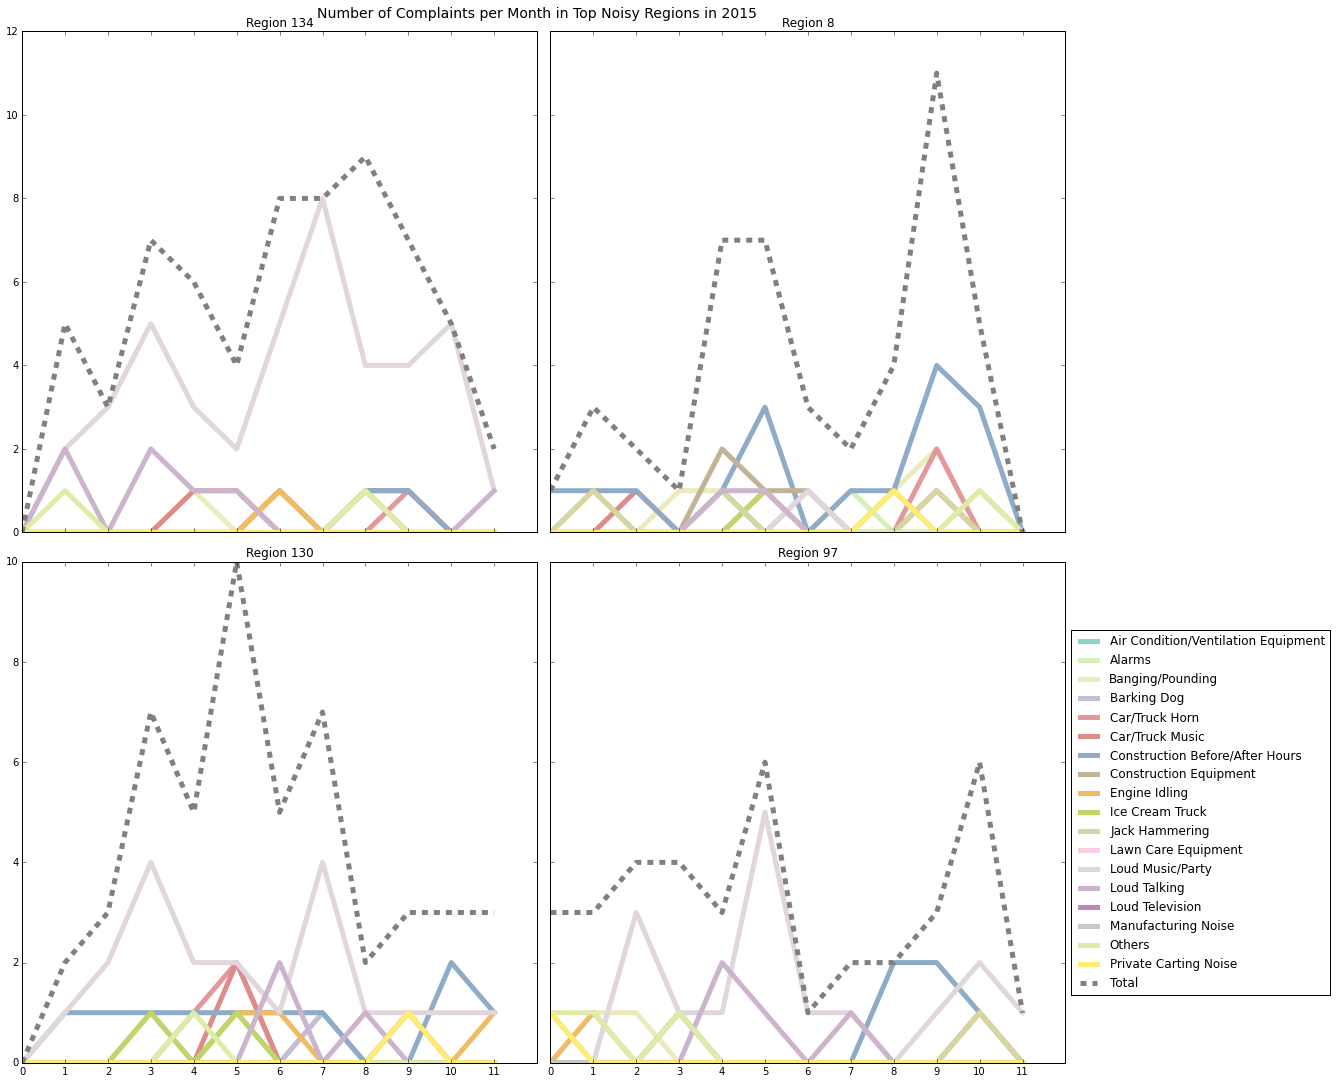

In [12]:
y = range(complaints_month.shape[1])
f, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 15))
for i in range(complaints_hour.shape[0]):
    axes[0][0].plot(y, complaints_month_134[i,:], label=keys[i], color=colors[i], linewidth=5)
    axes[0][1].plot(y, complaints_month_8[i,:],   label=keys[i], color=colors[i], linewidth=5)
    axes[1][0].plot(y, complaints_month_130[i,:], label=keys[i], color=colors[i], linewidth=5)
    axes[1][1].plot(y, complaints_month_97[i,:],  label=keys[i], color=colors[i], linewidth=5)
axes[0][0].plot(y, numpy.sum(complaints_month_134, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
axes[0][1].plot(y, numpy.sum(complaints_month_8, axis=0),   label='Total', color='gray', linewidth=5, linestyle='--')
axes[1][0].plot(y, numpy.sum(complaints_month_130, axis=0), label='Total', color='gray', linewidth=5, linestyle='--')
axes[1][1].plot(y, numpy.sum(complaints_month_97, axis=0),  label='Total', color='gray', linewidth=5, linestyle='--')
axes[0][0].set_title('Region 134')
axes[0][1].set_title('Region 8')
axes[1][0].set_title('Region 130')
axes[1][1].set_title('Region 97')
plt.suptitle('Number of Complaints per Month in Top Noisy Regions in 2015', fontsize=14, x=0.5, y=1.0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.setp(axes, xticks=range(12))
plt.tight_layout()

**Washington Heights** (134) presents three peaks of noise complaints. One is in *February*, followed by another in *March* and finally one in *August*. Its interest to note that the first one are dominate by **Loud Talking** and **Loud Music/Party**, instead of just **Loud Music/Party**. Also, in February is winter, this complaints may be related to private/indoors parties, i.e., maybe those are peolple complaint about their neighbors. On the other hand, in *March*  we can see the dominance of **Loud Music Party**. In this monht, it starts to warm again, which may be related to this observation somehow. At last, we can see an increase in the number of complaints in *June*. At this point, the summer vacation is approaching. Public places in this region [host performances and markets over several weeks each summer](https://en.wikipedia.org/wiki/Washington_Heights,_Manhattan#Community) which may justify this peak.

The **Upper East Side** (8), once again, presents its majority of complaints related to **Construction Before/After Hours**. It's also possible to notice the appearance of complaints related to **Construction Equipment** and **Jack Hammering**, which seems to reforce what was presented earlier regarding this region development.

**Williamsburg/Greenpoint** (130) presents its peak on *June* (summer), with a combination of complaints realted to **Loud Music/Party**, **Car Truck Music**, **Ice Cream Truck** and **Car/Truck Horn**. This seems to be consistent with which would be expected in this period of time. Starting in *September*, the number of complaints related to **Loud Music/Party** drops, probalby because of the winter season approaching. 

Finally **Greenwich Village/SoHo/Little Italy/West Village** (97), also shows its peak in *June*, with complaints related to **Loud Music/Party** and **Loud Talking**. In *August*, we can see that the number of complaints related to **Construction Before/After Hour** grows, decreasing two months later. 

## Looking Deeper - Taking a look in the complaints by day of 2015

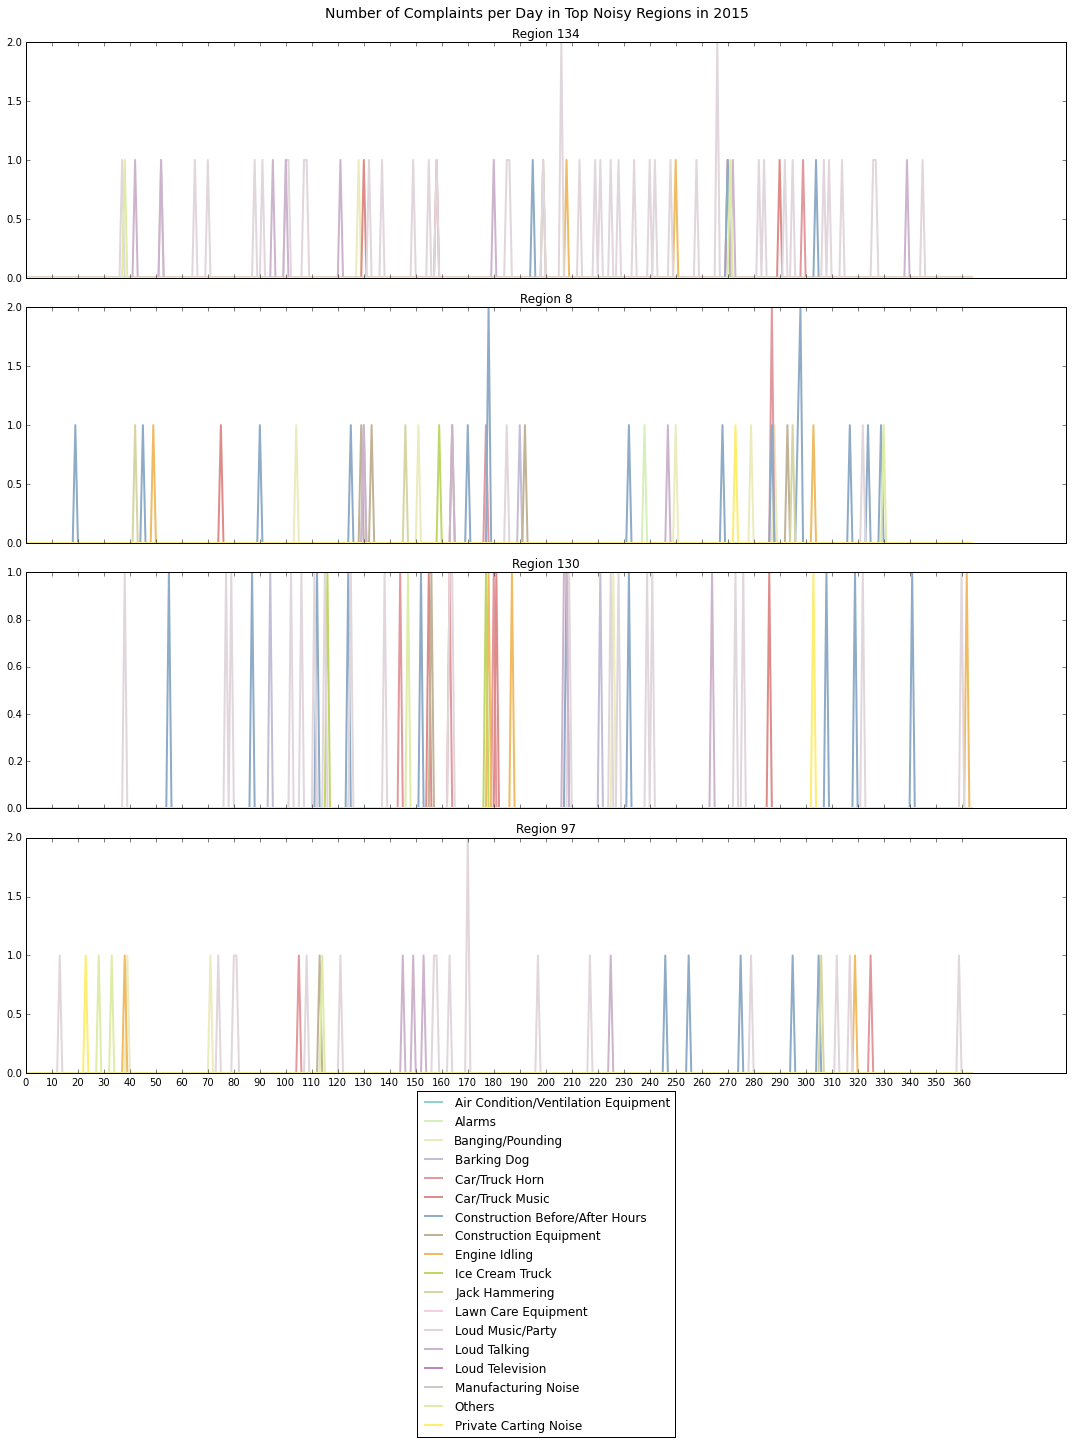

In [13]:
y = range(complaints_day.shape[1])
f, axes = plt.subplots(4, 1, sharex='col', figsize=(15, 15))
for i in range(complaints_day.shape[0]):
    axes[0].plot(y, complaints_day_134[i,:], label=keys[i], color=colors[i], linewidth=2)
    axes[1].plot(y, complaints_day_8[i,:],   label=keys[i], color=colors[i], linewidth=2)
    axes[2].plot(y, complaints_day_130[i,:], label=keys[i], color=colors[i], linewidth=2)
    axes[3].plot(y, complaints_day_97[i,:],  label=keys[i], color=colors[i], linewidth=2)
axes[0].set_title('Region 134')
axes[1].set_title('Region 8')
axes[2].set_title('Region 130')
axes[3].set_title('Region 97')
plt.suptitle('Number of Complaints per Day in Top Noisy Regions in 2015', fontsize=14, x=0.5, y=1.01)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
plt.setp(axes, xticks=numpy.arange(0, 365, 10))
plt.tight_layout()

### \#TODO: correlated this with construction events to observe if they affect the number of complaints related to *Car/Truck Horn*, *Construction Before/After Hours*,  *Construction Equipment* and *Banging/Pounding*.